In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf # pip install tensorflow-macos
import os
tf.random.set_seed(1)

# Introduction to Transfer Learning in TensorFlow Part 2: Fine-tuning
- unlike feature extraction, in fine-tuning, we unfreeze some or all of the layers and retrain them on our own data

# Importing a script full of helper functions (and saving lots of space)

In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Downloading and turning our images into a TensorFlow BatchDataset

In [3]:
zip_path = "10_food_classes_10_percent.zip"
if not os.path.isfile(zip_path):
    os.chdir("data")
unzip_data(zip_path)
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [4]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [6]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[192.         239.         245.        ]
   [192.         239.         247.        ]
   [189.78572    236.57143    247.21428   ]
   ...
   [143.71938    132.71938    102.71938   ]
   [142.64285    131.64285    103.64286   ]
   [143.22961    132.22961    104.229614  ]]

  [[191.         238.         244.        ]
   [191.07143    238.07143    246.07143   ]
   [190.80103    237.58673    248.22958   ]
   ...
   [144.94388    131.21426    101.4031    ]
   [144.         130.         101.        ]
   [144.         130.         101.        ]]

  [[191.78572    238.78572    246.35715   ]
   [192.7296     239.7296     247.7296    ]
   [191.78572    238.57144    249.2143    ]
   ...
   [144.99998    130.42854     97.64284   ]
   [144.78572    130.          99.42857   ]
   [144.78572    130.          99.42857   ]]

  ...

  [[184.56639    182.48985    160.63274   ]
   [184.22461    182.01031    161.4389    ]
   [174.78078    172.56648    151.99507   ]
   ...
   [101.61742     71.617

2023-05-10 17:35:17.638746: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Creating our first model with the TensorFlow Keras Functional API
- [from here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0)

In [8]:
# tf.keras.applications.efficientnet.EfficientNetB0(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation='softmax',
#     **kwargs
# )

# 1) Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # don't include top layer because it defaults to imagenet's 1000 outputs, we want 10

# 2) freeze the base model so the underlying pretrained layers aren't changed in training
base_model.trainable = False

# 3) create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4) normalize inputs (needed for ResNet50V2)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/225)(inputs)

# 5) pass inputs into base model
x = base_model(inputs)
print(f"shape after inputs: {x.shape}")

# 6) Average pool the outputs of the base model (aggregate all the most important information
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7) Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8) Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9) Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

shape after inputs: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


# fitting our first Functional API model

In [9]:
# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")]
                                 )

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230510-173518


Epoch 1/5
24/24 [==============================] - 25s 982ms/step - loss: 1.8098 - accuracy: 0.4627 - val_loss: 1.2069 - val_accuracy: 0.7648
Epoch 2/5
24/24 [==============================] - 23s 955ms/step - loss: 1.0705 - accuracy: 0.7733 - val_loss: 0.8317 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 24s 999ms/step - loss: 0.7739 - accuracy: 0.8240 - val_loss: 0.6882 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 23s 982ms/step - loss: 0.6253 - accuracy: 0.8600 - val_loss: 0.5768 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 27s 1s/step - loss: 0.5412 - accuracy: 0.8827 - val_loss: 0.5136 - val_accuracy: 0.8750


In [10]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [11]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [12]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


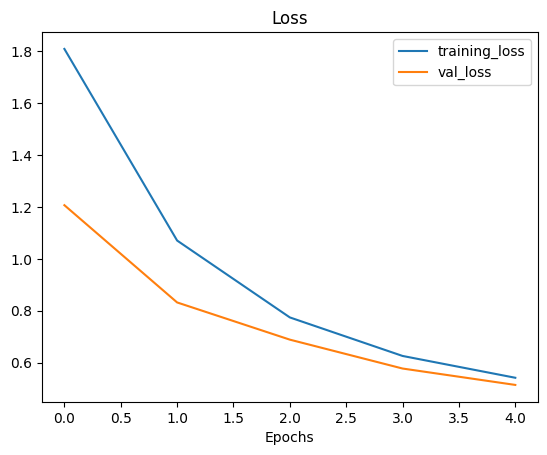

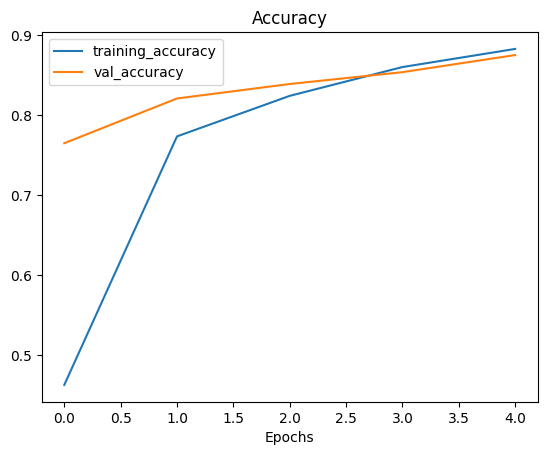

In [13]:
# Model's training curves
plot_loss_curves(history_10_percent)

# Getting a feature vector from our trained model
- The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [14]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


as we can see above, tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3). It did so by averaging the input_tensor across the middle two axes.

# Downloading and preparing the data for Model 1 (1 percent of training data)
1. model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation

In [17]:
zip_path = "10_food_classes_1_percent.zip"
if not os.path.isfile(zip_path):
    os.chdir("data")
unzip_data(zip_path)
walk_through_dir("10_food_classes_1_percent")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

### data loaders

In [18]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Building a data augmentation layer to use inside our model

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

### making data augmentation into a layer means that if you save and export the model, it'll apply the augmentation when loaded
- the augmentation happens during training (enables GPU acceleration)

In [20]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Visualizing what happens when images pass through our data augmentation layer

In [22]:
import matplotlib.image as mpimg
import random

(-0.5, 609.5, 376.5, -0.5)

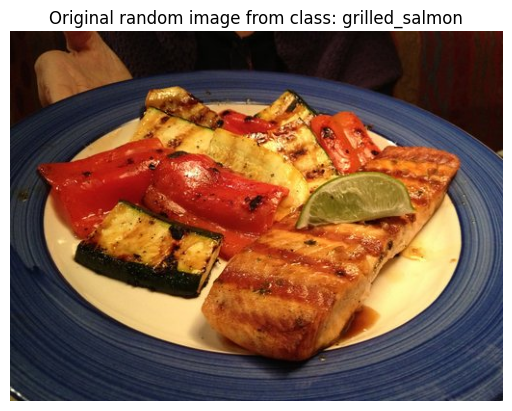

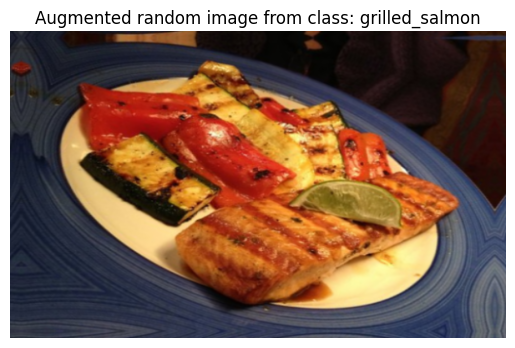

In [29]:
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False) # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

### same as above but functionized

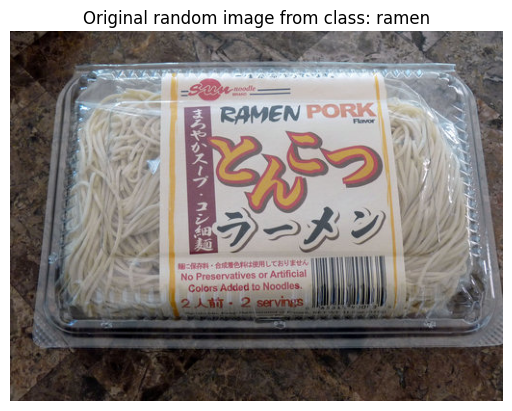

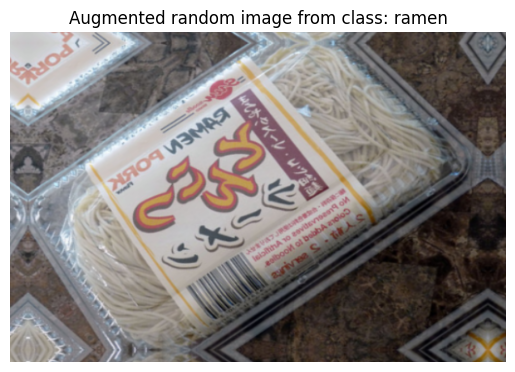

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import tensorflow as tf

def plot_augmented_image(train_data_location: str, train_data: list, data_augmentation: tf.keras.layers):
    """
    This function takes as arguments the location of the training data, the training data itself and the data augmentation layer.
    It selects a random image from the training data, displays it, applies the data augmentation layer to it and displays the augmented image.

    Parameters:
    train_data_location (str): Location of the training data.
    train_data (tf.data.Dataset): Training data.
    data_augmentation (tf.keras.Sequential): Data augmentation layer.

    Returns:
    None
    """

    target_class = random.choice(train_data.class_names) # choose a random class
    target_dir = os.path.join(train_data_location, target_class) # create the target directory
    random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
    random_image_path = os.path.join(target_dir, random_image) # create the chosen random image path
    img = mpimg.imread(random_image_path) # read in the chosen target image
    plt.imshow(img) # plot the target image
    plt.title(f"Original random image from class: {target_class}")
    plt.axis(False) # turn off the axes

    # Augment the image
    augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
    plt.figure()
    plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
    plt.title(f"Augmented random image from class: {target_class}")
    plt.axis(False)

plot_augmented_image("10_food_classes_1_percent/train/", train_data_1_percent, data_augmentation)

# Building Model 1 (with a data augmentation layer and 1% of training data)

In [33]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # don't include top bc we want our own layers
base_model.trainable = False # bc we just want the stuff trained from imagenet

# create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# add in augmented data as sequential layer
x = data_augmentation(inputs)

# give base_model inputs after augmentation and don't train it
x = base_model(x, training=False)

# pool output features of base model
x = layers.GlobalAveragePooling2D()(x)

# put dense layer for output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# make model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# compile
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
model_1_history = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=create_tensorboard_callback(dir_name="transfer_learning",
                                                                    experiment_name="1_percent_data_aug"))

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230510-230116


Epoch 1/5
3/3 [==============================] - 15s 6s/step - loss: 2.4087 - accuracy: 0.0857 - val_loss: 2.2944 - val_accuracy: 0.1151
Epoch 2/5
3/3 [==============================] - 11s 5s/step - loss: 2.1760 - accuracy: 0.2143 - val_loss: 2.1597 - val_accuracy: 0.2007
Epoch 3/5
3/3 [==============================] - 10s 5s/step - loss: 1.9570 - accuracy: 0.3286 - val_loss: 2.0295 - val_accuracy: 0.3026
Epoch 4/5
3/3 [==============================] - 11s 5s/step - loss: 1.7499 - accuracy: 0.5429 - val_loss: 1.9213 - val_accuracy: 0.3750
Epoch 5/5
3/3 [==============================] - 12s 5s/step - loss: 1.6131 - accuracy: 0.6571 - val_loss: 1.8244 - val_accuracy: 0.4572


pretty great for only 7 images per class!

In [35]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [37]:
# evaluate on full test data
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 39s 489ms/step - loss: 1.8354 - accuracy: 0.4372


In [38]:
results_1_percent_data_aug

[1.8354138135910034, 0.43720000982284546]

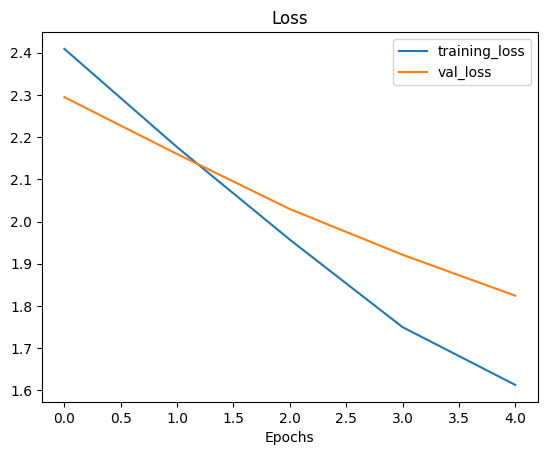

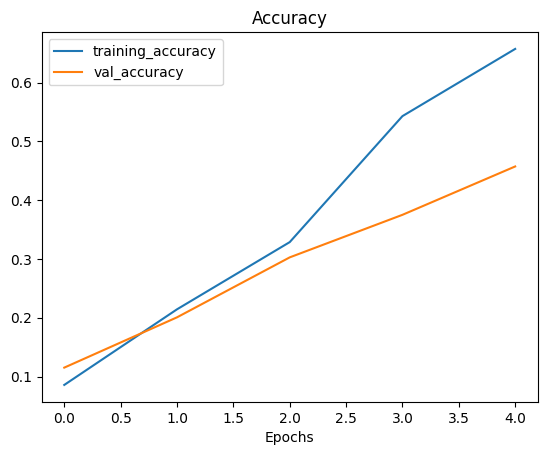

In [39]:
# how do the loss curves look?
plot_loss_curves(model_1_history)

# Building Model 2 (with a data augmentation layer and 10% of training data)

In [45]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [46]:
walk_through_dir(train_dir_10_percent)

There are 10 directories and 0 images in '10_food_classes_10_percent/train/'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.


In [47]:
# data inputs
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [48]:
# create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [50]:
# build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1/255) # this is commented out bc needed for Resnet50V2 but not EfficientNetB0 which has rescaling built in
], name="data_augmentation_layer")

In [54]:
input_shape = (224, 224, 3)

# create frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create inputs and outputs and layers between
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augments training images right away
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batch norm layers don't get updated. we want this even in fine tuning


x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling2d")(x) # turn base model into feature vector

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [55]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling2d (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

will fit in next module

# Creating a ModelCheckpoint to save our model's weights during training
- The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

- This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

- For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In [56]:
# set checkpoint path
checkpoint_path = "model_2_checkpoints/checkpoint.ckpt"

# create model checkpoint callback that saves weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False, # this probably makes more sense to be set to true
                                                         save_freq="epoch", # save every epoch
                                                         verbose=True)


# Fitting and evaluating Model 2 (and saving its weights using ModelCheckpoint)

In [57]:
# fit model 2 with checkpoint callback
initial_epochs = 5

model_2_history = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="model_2"),
                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_2/20230510-233120


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9620 - accuracy: 0.3680
Epoch 1: saving model to model_2_checkpoints/checkpoint.ckpt
24/24 [==============================] - 29s 1s/step - loss: 1.9620 - accuracy: 0.3680 - val_loss: 1.3433 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2850 - accuracy: 0.7053
Epoch 2: saving model to model_2_checkpoints/checkpoint.ckpt
24/24 [==============================] - 28s 1s/step - loss: 1.2850 - accuracy: 0.7053 - val_loss: 0.9129 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.7773
Epoch 3: saving model to model_2_checkpoints/checkpoint.ckpt
24/24 [==============================] - 24s 995ms/step - loss: 0.9872 - accuracy: 0.7773 - val_loss: 0.7231 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8460 - accuracy: 0.8027
Epoch 4: saving model to model_2_checkpoints/checkpoint

In [58]:
# model 0 results
model_0.evaluate(test_data)

79/79 [==============================] - 50s 616ms/step - loss: 0.5404 - accuracy: 0.8628


[0.5404439568519592, 0.8628000020980835]

In [ ]:
# model 1 results
# model_1.evaluate(test_data)

In [60]:
# model 2 results
model_2_results = model_2.evaluate(test_data)
model_2_results

79/79 [==============================] - 40s 498ms/step - loss: 0.6071 - accuracy: 0.8480


[0.6070533394813538, 0.8479999899864197]

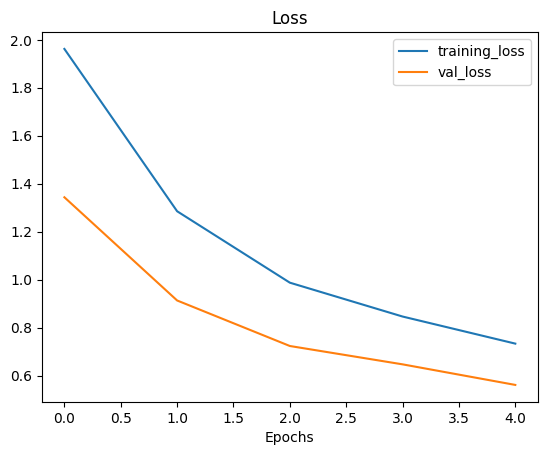

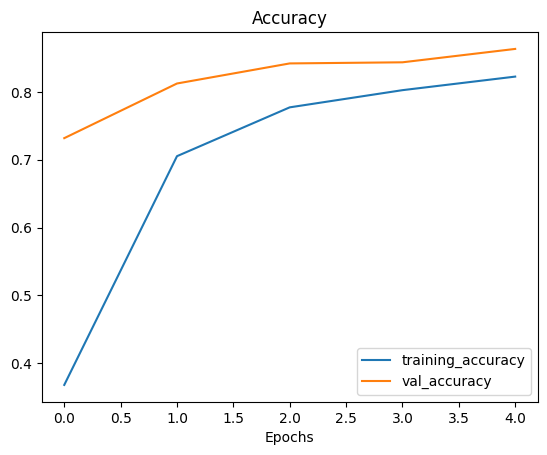

In [62]:
plot_loss_curves(model_2_history)

# Loading and comparing saved weights to our existing trained Model 2

In [63]:
model_2.load_weights(checkpoint_path)

In [65]:
# evaluate it with loaded weights (just to try, in this case, it may be the same off by floating point precision)
model_2_loaded_results = model_2.evaluate(test_data)

79/79 [==============================] - 34s 427ms/step - loss: 0.6071 - accuracy: 0.8480


In [69]:
# they're exactly the same, but could be sligtly off in future
model_2_loaded_results == model_2_results

True

In [67]:
# they're very close
np.isclose(np.array(model_2_loaded_results), np.array(model_2_results))

array([ True,  True])

In [68]:
print(np.array(model_2_results) - np.array(model_2_loaded_results))

[0. 0.]


# Preparing Model 3 (our first fine-tuned model)
- Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data
- model 3 is a fine tuned version of model 2 for 5 more epochs

In [70]:
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x299773a30> True
<keras.engine.sequential.Sequential object at 0x2be6f6e60> True
<keras.engine.functional.Functional object at 0x29bc501c0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x299c41390> True
<keras.layers.core.dense.Dense object at 0x29ba4e680> True


In [71]:
# what layers are in our base model, are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [72]:
# how many trainable variables in base model? 0 because we set base_model.trainable = False
print(len(model_2.layers[2].trainable_variables))

0


we want to make only last 10 trainable for fine tuning

To begin fine-tuning, we'll unfreeze the entire base model by setting its trainable attribute to True. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their trainable attribute to False. Finally, we'll recompile the model.

In [75]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False



# recompile model whenever we make a change
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # we often want to lower learning rate on fine tuning (bc those layers have already learned something). 10x is a good starting place
                metrics=["accuracy"])

In [76]:
print(len(model_2.trainable_variables))

12


In [74]:
# after the changes, what layers are in our base model, are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

# Fitting and evaluating Model 3 (our first fine-tuned model)

In [77]:
# fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# refit model (same as without fine-tuning, but has more trainable layers)
model_2_fine_tune_history = model_2.fit(train_data_10_percent,
                                        epochs=fine_tune_epochs,
                                        steps_per_epoch=(len(train_data_10_percent)),
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)),
                                        initial_epoch=model_2_history.epoch[-1], # start training from previous last epoch
                                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                               experiment_name="fist_fine_tune")])


Saving TensorBoard log files to: transfer_learning/fist_fine_tune/20230511-092701


Epoch 5/10
24/24 [==============================] - 24s 940ms/step - loss: 0.6213 - accuracy: 0.8213 - val_loss: 0.4299 - val_accuracy: 0.8651
Epoch 6/10
24/24 [==============================] - 23s 947ms/step - loss: 0.5065 - accuracy: 0.8520 - val_loss: 0.4118 - val_accuracy: 0.8635
Epoch 7/10
24/24 [==============================] - 23s 965ms/step - loss: 0.4580 - accuracy: 0.8600 - val_loss: 0.4026 - val_accuracy: 0.8553
Epoch 8/10
24/24 [==============================] - 24s 1s/step - loss: 0.4073 - accuracy: 0.8813 - val_loss: 0.3879 - val_accuracy: 0.8635
Epoch 9/10
24/24 [==============================] - 23s 962ms/step - loss: 0.3697 - accuracy: 0.8947 - val_loss: 0.3701 - val_accuracy: 0.8701
Epoch 10/10
24/24 [==============================] - 28s 1s/step - loss: 0.3258 - accuracy: 0.9027 - val_loss: 0.3619 - val_accuracy: 0.8701


evaluating fine tune model

In [78]:
model_2_fine_tune_results = model_2.evaluate(test_data)

79/79 [==============================] - 45s 564ms/step - loss: 0.4175 - accuracy: 0.8596


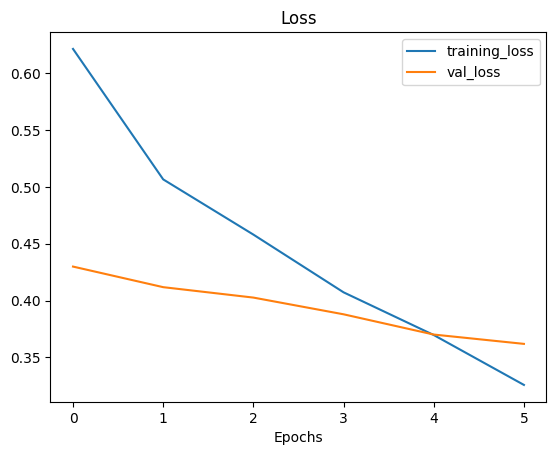

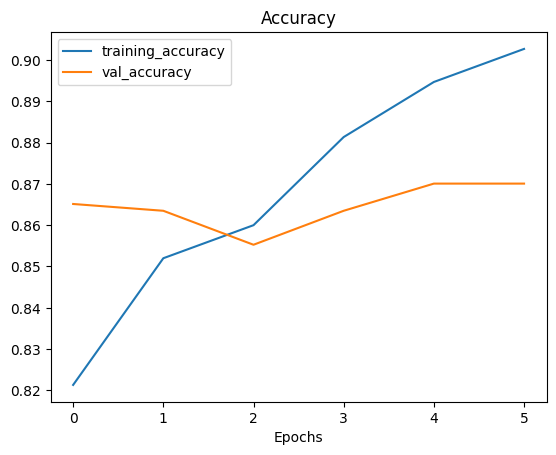

In [79]:
# this didn't plot properly for after fine tuning
plot_loss_curves(model_2_fine_tune_history)

# Comparing our model's results before and after fine-tuning

In [80]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.36800000071525574, 0.7053333520889282, 0.7773333191871643, 0.8026666641235352, 0.8226666450500488, 0.8213333487510681, 0.8519999980926514, 0.8600000143051147, 0.8813333511352539, 0.8946666717529297, 0.9026666879653931]


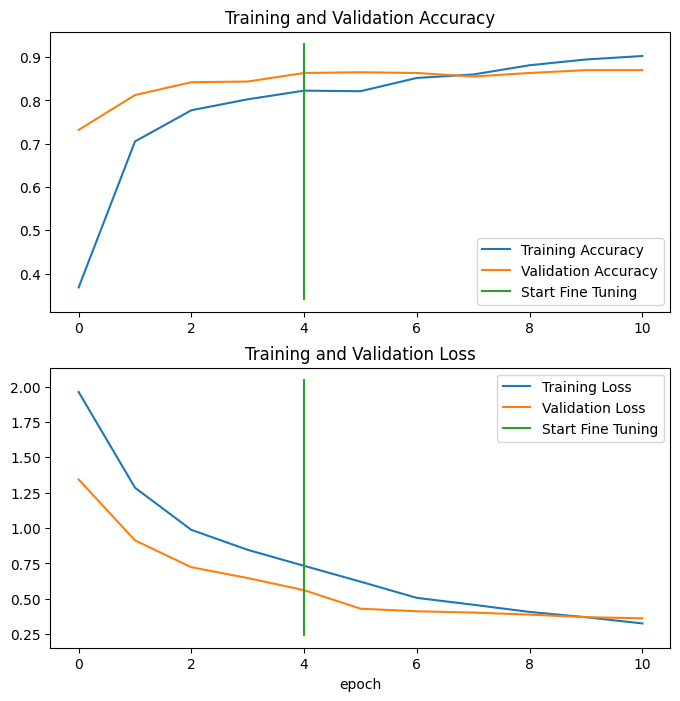

In [81]:
compare_historys(model_2_history, model_2_fine_tune_history, initial_epochs=5)

# Downloading and preparing data for our biggest experiment yet (Model 4)

In [82]:
zip_path = "10_food_classes_all_data.zip"
if not os.path.isfile(zip_path):
    os.chdir("data")
unzip_data(zip_path)
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [85]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [86]:
# setup data inputs
IMG_SIZE = (224, 224)
train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                             image_size=IMG_SIZE,
                                                                             label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Preparing our final modelling experiment (Model 4)
- all experiments have used the same test data

In [87]:
model_2_fine_tune_results

[0.41747406125068665, 0.8596000075340271]

to train the fine tuning model, we need to revert model 2 back to its feature extraction weights

In [88]:
# load from checkpoints
model_2.load_weights(checkpoint_path)

In [89]:
model_2_reset_results = model_2.evaluate(test_data)

79/79 [==============================] - 42s 525ms/step - loss: 0.6071 - accuracy: 0.8480


In [90]:
model_2_reset_results

[0.6070533394813538, 0.8479999899864197]

In [91]:
model_2_reset_results == model_2_results
# so its back at the feature extraction only performance

True

### we just
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data

In [92]:
# check which layers are trainable
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

# the layers we set up are still trainable as we set up for model 3 even though we reset weights bc we only changed weights

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_avg_pooling2d True
4 output_layer True


In [93]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

# Fine-tuning Model 4 on 100% of the training data and evaluating its results

In [94]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [95]:
fine_tune_epochs = initial_epochs + 5

model_4_history = model_2.fit(train_data_100_percent,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data_100_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=model_2_history.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="model_4")])

Saving TensorBoard log files to: transfer_learning/model_4/20230511-100002


Epoch 5/10
235/235 [==============================] - 156s 652ms/step - loss: 0.6448 - accuracy: 0.7944 - val_loss: 0.3557 - val_accuracy: 0.8832
Epoch 6/10
235/235 [==============================] - 144s 614ms/step - loss: 0.5251 - accuracy: 0.8315 - val_loss: 0.3145 - val_accuracy: 0.9030
Epoch 7/10
235/235 [==============================] - 155s 659ms/step - loss: 0.4670 - accuracy: 0.8453 - val_loss: 0.2777 - val_accuracy: 0.9095
Epoch 8/10
235/235 [==============================] - 161s 684ms/step - loss: 0.4153 - accuracy: 0.8643 - val_loss: 0.2633 - val_accuracy: 0.9079
Epoch 9/10
235/235 [==============================] - 153s 649ms/step - loss: 0.3871 - accuracy: 0.8731 - val_loss: 0.2592 - val_accuracy: 0.9013
Epoch 10/10
235/235 [==============================] - 157s 667ms/step - loss: 0.3658 - accuracy: 0.8803 - val_loss: 0.2412 - val_accuracy: 0.9145


this is veeeery slow on my mac. really need a GPU. took about 15 minutes

In [96]:
# evaluate all test data
model_4_results = model_2.evaluate(test_data)

79/79 [==============================] - 44s 560ms/step - loss: 0.2684 - accuracy: 0.9132


5
11
[0.36800000071525574, 0.7053333520889282, 0.7773333191871643, 0.8026666641235352, 0.8226666450500488, 0.7943999767303467, 0.8314666748046875, 0.8453333377838135, 0.8642666935920715, 0.8730666637420654, 0.8802666664123535]


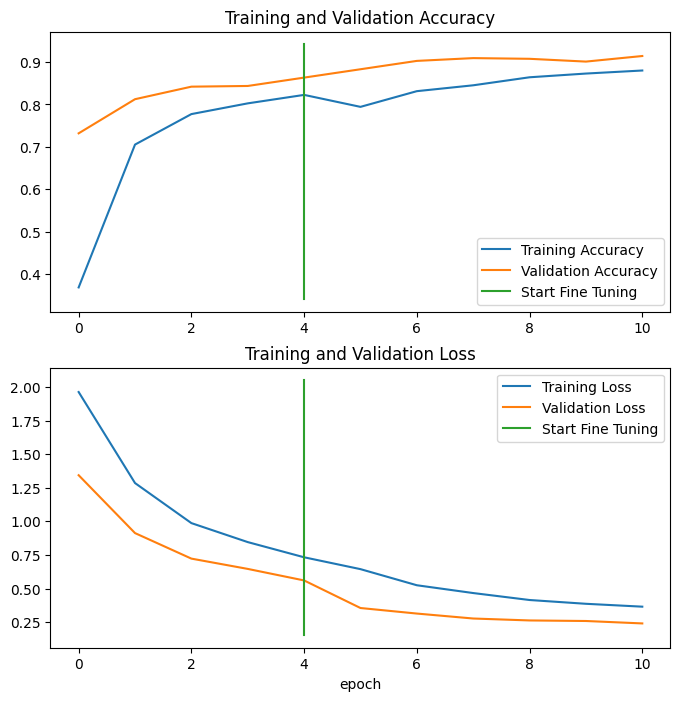

In [97]:
# how did it go with more data
compare_historys(model_2_history, model_4_history)